In [1]:
from keras.applications import VGG16
from vis.utils import utils
from keras import activations

from __future__ import print_function
import warnings
from os import environ
from PIL import Image

Image.MAX_IMAGE_PIXELS = None
warnings.simplefilter('ignore', Image.DecompressionBombWarning)
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, AveragePooling2D, Input, Flatten, Activation, Dropout, Dense
from keras.optimizers import Adam, SGD
from keras.initializers import glorot_normal
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.regularizers import l2
from keras import backend as K
from keras.models import Sequential, Model
from os import path, getcwd
import pandas as pd
import random
import numpy as np
import shutil

Using TensorFlow backend.


In [8]:
num_artists = 57
input_shape = (224, 224, 3)


In [ ]:
vgg16 = VGG16(include_top=False, weights='imagenet', input_shape=(224,224,3))

x = vgg16.output
x = Dense(128, activation='sigmoid')(x)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.2)(x)
preds_layer = Dense(num_artists, activation='linear', name='predictions')(x)

transfer_vgg16 = Model(inputs=vgg16.input, outputs=preds_layer)

for layer in vgg16.layers:
    layer.trainable = False

In [ ]:
transfer_vgg16.load_weights('/home/student1/ivsenki/Desktop/transfer300/transfer-vgg16.weights4.07--0.37602.hdf5')
#transfer_vgg16.compile(loss='categorical_crossentropy',
#                     optimizer=SGD(lr=1e-3, momentum=0.9),
#                     metrics=['accuracy'])

In [ ]:
layer_idx = utils.find_layer_idx(transfer_vgg16, 'predictions')

# Swap softmax with linear
transfer_vgg16.layers[layer_idx].activation = activations.linear
transfer_vgg16 = utils.apply_modifications(transfer_vgg16)

In [ ]:
transfer_vgg16.summary()

# Visualizing a specific output category

In [ ]:
from vis.visualization import visualize_activation
from matplotlib import pyplot as plt
from vis.input_modifiers import Jitter

%matplotlib inline

plt.rcParams['figure.figsize'] = (18, 6)

# 20 is the imagenet category for 'ouzel'
img = visualize_activation(transfer_vgg16, layer_idx, filter_indices=20, max_iter=500, input_modifiers=[Jitter(16)])
plt.imshow(img)

In [ ]:
"""

VIŠE KATEGORIJA

import numpy as np
categories = np.random.permutation(1000)[:15]

vis_images = []
image_modifiers = [Jitter(16)]
for idx in categories:    
    img = visualize_activation(model, layer_idx, filter_indices=idx, max_iter=500, input_modifiers=image_modifiers)
    
    # Reverse lookup index to imagenet label and overlay it on the image.
    img = utils.draw_text(img, utils.get_imagenet_label(idx))
    vis_images.append(img)

# Generate stitched images with 5 cols (so it will have 3 rows).
plt.rcParams['figure.figsize'] = (50, 50)
stitched = utils.stitch_images(vis_images, cols=5)
plt.axis('off')
plt.imshow(stitched)
plt.show()
"""

# Visualizing Conv filters

In [ ]:
from vis.visualization import get_num_filters, visualize_activation
from keras_preprocessing.image import save_img
from matplotlib import pyplot as plt
from vis.input_modifiers import Jitter

%matplotlib inline

# The name of the layer we want to visualize
# You can see this in the model definition.
layer_name = 'block1_conv2'
layer_idx = utils.find_layer_idx(transfer_vgg16, layer_name)

# Visualize first 32 filters in this layer.
filters = np.arange(get_num_filters(transfer_vgg16.layers[layer_idx])//32)

# Generate input image for each filter.
vis_images = []
for idx in filters:
    img = visualize_activation(transfer_vgg16, layer_idx, filter_indices=idx)
    
    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    vis_images.append(img)

# Generate stitched image palette with 8 cols.
stitched = utils.stitch_images(vis_images, cols=8)    
plt.axis('off')
plt.imshow(stitched)
plt.title(layer_name)
plt.show()

In [ ]:
save_img('proba.png', stitched)

In [ ]:
selected_indices = []
for layer_name in ['block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']:
    layer_idx = utils.find_layer_idx(transfer_vgg16, layer_name)

    # Visualize all filters in this layer.
    filters = np.random.permutation(get_num_filters(transfer_vgg16.layers[layer_idx]))[:10]
    selected_indices.append(filters)

    # Generate input image for each filter.
    vis_images = []
    for idx in filters:
        img = visualize_activation(transfer_vgg16, layer_idx, filter_indices=idx)

        # Utility to overlay text on image.
        img = utils.draw_text(img, 'Filter {}'.format(idx))    
        vis_images.append(img)

    # Generate stitched image palette with 5 cols so we get 2 rows.
    stitched = utils.stitch_images(vis_images, cols=5)    
    plt.figure()
    plt.axis('off')
    plt.imshow(stitched)
    plt.show()

In [ ]:
# Generate input image for each filter.
new_vis_images = []
for i, idx in enumerate(filters):
    # We will seed with optimized image this time.
    img = visualize_activation(transfer_vgg16, layer_idx, filter_indices=idx, 
                               seed_input=vis_images[i],
                               input_modifiers=[Jitter(0.05)])

    # Utility to overlay text on image.
    img = utils.draw_text(img, 'Filter {}'.format(idx))    
    new_vis_images.append(img)

# Generate stitched image palette with 5 cols so we get 2 rows.
stitched = utils.stitch_images(new_vis_images, cols=5)    
plt.figure()
plt.axis('off')
plt.imshow(stitched)
plt.show()

# SALIENCY MAPS

In [ ]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations
from keras_preprocessing.image import save_img
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

gogh = utils.load_img('/home/student1/ivsenki/Desktop/transfer300/testGogh.jpg', target_size=(224, 224))
picasso = utils.load_img('/home/student1/ivsenki/Desktop/Vje-ba/testPicasso.jpg', target_size=(224, 224))

f, ax = plt.subplots(1, 2)
ax[0].imshow(gogh)
ax[1].imshow(picasso)

layer_idx = utils.find_layer_idx(transfer_vgg16, 'predictions')

f, ax = plt.subplots(1, 2)
  
# 20 is the index corresponding to picasso
grad_picasso = visualize_saliency(transfer_vgg16, 
                           layer_idx, 
                           filter_indices=28,
                           seed_input=picasso)

grad_gogh = visualize_saliency(transfer_vgg16, 
                           layer_idx, 
                           filter_indices=28,
                           seed_input=gogh)

# visualize grads as heatmap
# ax[i].imshow(grad_picasso, cmap='jet')
save_img('proba-sal1.png', grad_picasso)

# Categorical Dense layer visualization

By setting layer_idx to final Dense layer, and filter_indices to the desired output category, we can visualize parts of the seed_input that contribute most towards activating the corresponding output nodes,

For multi-class classification, filter_indices can point to a single class.
For multi-label classifier, simply set the appropriate filter_indices.


In [18]:
from __future__ import print_function
import warnings
from os import environ
from PIL import Image

Image.MAX_IMAGE_PIXELS = None
warnings.simplefilter('ignore', Image.DecompressionBombWarning)
environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.layers import Dense, Conv2D, BatchNormalization, Activation, MaxPooling2D, Flatten
from keras.optimizers import Adam
from keras.initializers import glorot_normal
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.regularizers import l2
from keras import backend as K
from keras.models import Sequential
from keras.preprocessing import image
from os import path, getcwd
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import random
import numpy as np
import shutil

In [13]:
def center_crop(img, center_crop_size):
    assert img.shape[2] == 3
    centerw, centerh = img.shape[0] // 2, img.shape[1] // 2
    halfw, halfh = center_crop_size[0] // 2, center_crop_size[1] // 2
    return img[centerw-halfw:centerw+halfw, centerh-halfh:centerh+halfh, :]

# https://jkjung-avt.github.io/keras-image-cropping/
def random_crop(img, random_crop_size):
    # Note: image_data_format is 'channel_last'
    assert img.shape[2] == 3
    height, width = img.shape[0], img.shape[1]
    dy, dx = random_crop_size
    x = np.random.randint(0, width - dx + 1)
    y = np.random.randint(0, height - dy + 1)
    return img[y:(y+dy), x:(x+dx), :]

# https://jkjung-avt.github.io/keras-image-cropping/
def crop_generator(batches, crop_length, random_cropping=True, test_batch=False):
    '''
    Take as input a Keras ImageGen (Iterator) and generate random
    crops from the image batches generated by the original iterator
    '''
    while True:
        if test_batch == False:
            batch_x, batch_y = next(batches)
        else:
            batch_x = next(batches)
        batch_crops = np.zeros((batch_x.shape[0], crop_length, crop_length, 3))
        for i in range(batch_x.shape[0]):
            if random_cropping == True:
                batch_crops[i] = random_crop(batch_x[i], (crop_length, crop_length))
            else:
                batch_crops[i] = center_crop(batch_x[i], (crop_length, crop_length))
        if test_batch == False:
            yield (batch_crops, batch_y)
        else:
            yield batch_crops

In [15]:
b_size = 60
num_artists = 57
test_datagen = ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
                '../test',
                batch_size=b_size,
                class_mode=None, # this means our generator will only yield batches of data, no labels
                shuffle=False)   # our data will be in order

# na slikama iz test skupa radimo centralni crop
test_crops = crop_generator(test_generator, 224, False, True)

# moramo staviti plus jedan jer 1710 nije djeljivo s 60
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size + 1

# velicina slika koje dajemo ulaznom sloju mreze
input_shape = (224, 224, 3)

Found 1710 images belonging to 57 classes.


In [4]:
b_size = 60

In [5]:
train_datagen = ImageDataGenerator(horizontal_flip=True)
train_generator = train_datagen.flow_from_directory(
                        '../train',
                        batch_size=b_size,
                        class_mode='categorical')

Found 13680 images belonging to 57 classes.


In [9]:
"""Konstruira i inicijalizira osnovnu konvolucijsku neuronsku mrežu"""
model = Sequential()
model.add(Conv2D(32,
                kernel_size=3, 
                strides=2, 
                padding='same', 
                input_shape=input_shape,
                kernel_initializer=glorot_normal()))

model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(32, 
                kernel_size=3, 
                strides=2, 
                padding="same", 
                input_shape=input_shape,
                kernel_initializer=glorot_normal()))

model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(4*num_artists, 
                input_shape=(6272,),
                kernel_initializer=glorot_normal()))
model.add(Activation('relu'))
model.add(Dense(num_artists, 
                input_shape=(4*num_artists,),
                activation='softmax',
                kernel_initializer=glorot_normal()))

# koristimo adamov optimizator i metrika je točnost
model.compile(loss='categorical_crossentropy',
            optimizer=Adam(lr=1e-4),
            metrics=['accuracy'])

# crta tablicu slojeva mreže
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 112, 112, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 112, 112, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 112, 112, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
__________

In [10]:
model.load_weights('Baseline-300.h5')

In [9]:
predictions = model.predict_generator(test_crops, 
                                    steps=STEP_SIZE_TEST,
                                    workers=4,
                                    verbose=1)
# np.save(open('predictions_base_test.npy', 'wb'), predictions)

29/29 [==============================] - 135s 5s/step


In [11]:
# ucitaj vec spremljene predikcije

predictions2 = np.load('predictions_base_test.npy')

In [16]:
preds = np.argmax(predictions2, axis=-1) # multiple categories

label_map = (train_generator.class_indices)
label_map = dict((v,k) for k,v in label_map.items()) # flip k,v
preds_names = [label_map[k] for k in preds]

        
print("Točnost: " + str((sum(preds == test_generator.classes)/len(preds))*100) + " %")

Točnost: 37.6608187134503 %


In [19]:
cm = confusion_matrix(test_generator.classes, preds)
report = classification_report(test_generator.classes, preds)

In [20]:
print("Scoreovi za pojedine autore:\n" + report)

Scoreovi za pojedine autore:
             precision    recall  f1-score   support

          0       0.48      0.50      0.49        30
          1       0.52      0.57      0.54        30
          2       0.43      0.53      0.48        30
          3       0.41      0.47      0.44        30
          4       0.38      0.17      0.23        30
          5       0.41      0.37      0.39        30
          6       0.42      0.43      0.43        30
          7       0.15      0.13      0.14        30
          8       0.34      0.33      0.34        30
          9       0.22      0.30      0.25        30
         10       0.18      0.20      0.19        30
         11       0.29      0.33      0.31        30
         12       0.74      0.57      0.64        30
         13       0.71      0.67      0.69        30
         14       0.68      0.70      0.69        30
         15       0.75      0.40      0.52        30
         16       0.62      0.87      0.72        30
         17     

# top-3 klasifikacije

In [37]:
top3_ind = []
for row in predictions2:
    idx = []
    temp = row
    for i in range(3):
        max_idx = np.argmax(temp, axis=0)
        idx.append(max_idx)
        temp = np.delete(temp, max_idx)
    top3_ind.append(idx)

In [41]:
suma = 0
for i in range(len(top3_ind)):
    if test_generator.classes[i] in top3_ind[i]:
        suma += 1
        
tocnost_top3 = suma/len(top3_ind)
print("tocnost top-3 klasifikacije " + str(tocnost_top3*100))

tocnost top-3 klasifikacije 47.251461988304094


In [44]:
def top3_točnost(predictions, test_generator):
    top3_ind = []
    for row in predictions:
        idx = []
        temp = row
        for i in range(3):
            max_idx = np.argmax(temp, axis=0)
            idx.append(max_idx)
            temp = np.delete(temp, max_idx)
        top3_ind.append(idx)
        
    suma = 0
    for i in range(len(top3_ind)):
        if test_generator.classes[i] in top3_ind[i]:
            suma += 1

    tocnost = suma/len(top3_ind)
    print("tocnost top-3 klasifikacije " + str(tocnost*100) + " %")
    
    return tocnost

In [45]:
print(top3_točnost(predictions2, test_generator))

tocnost top-3 klasifikacije 47.251461988304094 %
0.47251461988304094


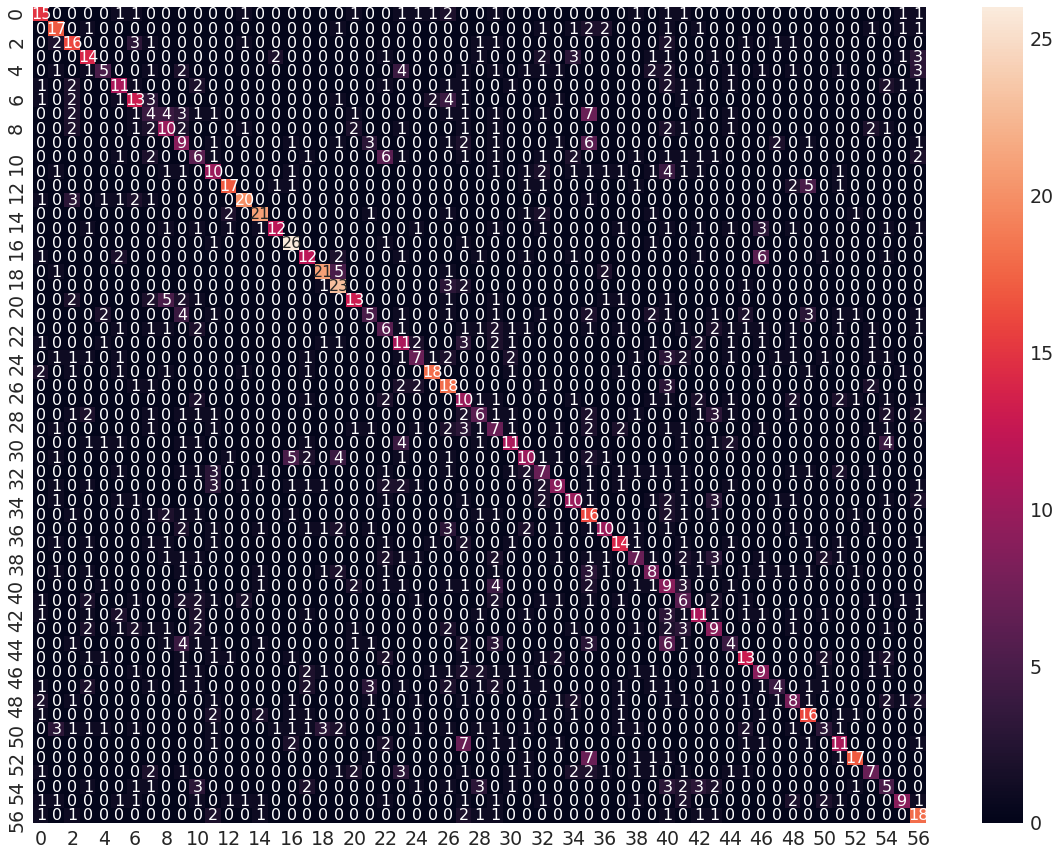

<Figure size 432x288 with 0 Axes>

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

df_cm = pd.DataFrame(cm)
plt.figure(figsize = (20,15))
sns.set(font_scale=1.9)#for label size

sns.set_style("darkgrid")

sns.heatmap(df_cm, annot=True, annot_kws={"size": 16})# font size
plt.show()
plt.savefig("matrica_konfuzije.jpg")